<h1 align="center">Fine Tuning of PEGASUS For Summarizing News Articles</h1>

# Abstract


Pre-training with Extracted Gap-sentences for Abstractive SUmmarization Sequence-to-sequence models, or PEGASUS, uses self-supervised objective Gap Sentences Generation (GSG) to train a transformer encoder-decoder model.

After thinking about the problem statement closely, we realised transfer learning is the best approach. But the PEGASUS model is used for abstractive summarization, which means that all types of summarization results generated from it will be generalized. But our problem requires us to get a summary more news oriented. Therefore, we decided to fine tune the model.


## Import Libraries

Here we will be using the following libraries:
1. Transformers : This is our primary NLP library, offered by HuggingFace. We will use this for fine-tuning.
2. Datasets : This is the HuggingFace library used for importing datasets and working on them. 
3. Pandas: We faced multiple challenges with working on our dataset as a dataset object, so we simply converted it to a pandas dataframe for better data manipulation.
4. NLTK: Probably the most famous NLP Library, it offers a HUGE toolkit for NLP tasks.
5. Torch: PyTorch is a vastly used library used for working with neural networks. Here, it helps in training our fine tuned model.
6. TQDM & Warnings: Optional libraries used for ease of development.

In [1]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
import pandas as pd
import datasets
from datasets import load_dataset, concatenate_datasets, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import nltk
from nltk.tokenize import sent_tokenize

import tqdm
import torch 
import warnings
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load data

To fine-tune a model, one needs to employ some datasets. This is to make sure the model adapts to our needs. The dataset we used here are:

https://huggingface.co/datasets/ayoubkirouane/news_summary

https://huggingface.co/datasets/Mahendrakharra/BBC-News-Articles-Summaries

In [3]:
train_df_4k = load_dataset("ayoubkirouane/news_summary", split = 'train[:70%]')
train_df_2k = load_dataset("Mahendrakharra/BBC-News-Articles-Summaries", split = 'train[:70%]')

val_df_4k = load_dataset("ayoubkirouane/news_summary", split = 'train[70%:]')
val_df_2k = load_dataset("Mahendrakharra/BBC-News-Articles-Summaries", split = 'train[70%:]')

In [4]:

train_df = concatenate_datasets([train_df_4k, train_df_2k])
valid_df = concatenate_datasets([val_df_4k, val_df_2k])
train_df = train_df.remove_columns(['author', 'date', 'read_more', 'headlines'])
valid_df = valid_df.remove_columns(['author', 'date', 'read_more', 'headlines'])

In [5]:
#Converting to pandas dataframe
train_df = train_df.to_pandas()
valid_df = valid_df.to_pandas()

In [6]:
#Function to merge columns
def merge_col(df, col1, col2, new_col):
    df[new_col] = df[col1].fillna(df[col2])
    return df

In [7]:
#Merging columns to create a single article and summary column
merge_col(train_df, 'ctext', 'articles', 'article')
merge_col(valid_df, 'ctext', 'articles', 'article')
merge_col(train_df, 'summaries', 'text', 'summary')
merge_col(valid_df, 'summaries', 'text', 'summary')
train_df = train_df.drop(['ctext', 'summaries', 'text', 'articles'], axis = 1).dropna()
valid_df = valid_df.drop(['ctext', 'summaries', 'text', 'articles'], axis = 1).dropna()


In [8]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

## Data Preparation 

This cell visualizes the distribution of token lengths in the articles and summaries within the dataset. We did not really get very useful results from these graphs, however, they were a part of initial analysis

Token indices sequence length is longer than the specified maximum sequence length for this model (1067 > 1024). Running this sequence through the model will result in indexing errors


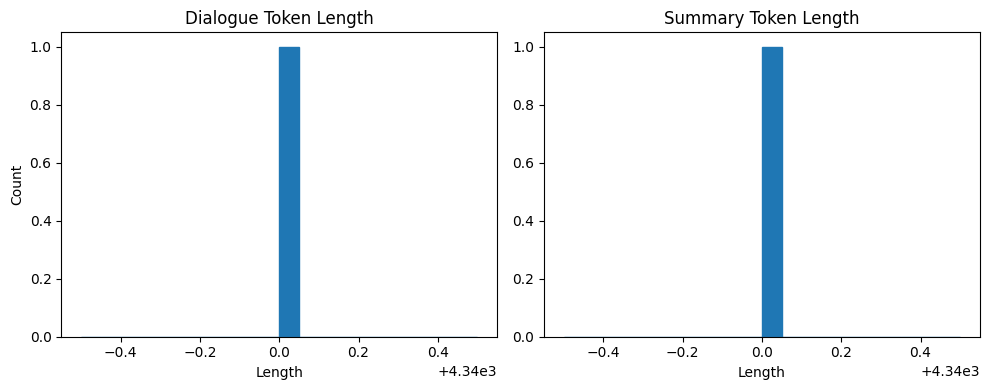

In [9]:
article_token_len = len([tokenizer.encode(s) for s in train_dataset['article']])

summary_token_len = len([tokenizer.encode(s) for s in train_dataset['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(article_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

The following function preprocesses the "article" and "summary" pairs into the format required for training a sequence-to-sequence (seq2seq) model.

It follows the following steps:
1. Tokenize Input Articles:
   - Extracts "article" text from each example.
   - Uses the provided tokenizer to segment the text into tokens, convert them to numerical IDs, and apply padding or special tokens as needed.
   - Sets a maximum length of 1024 tokens for each article, truncating longer ones.
   - Stores the results in the input_encodings dictionary.
2. Tokenize Target Summaries:
   - Enters a context using tokenizer.as_target_tokenizer(), potentially configuring the tokenizer for target text (e.g., using different special tokens).
   - Extracts "summary" text from each example.
   - Tokenizes the summaries using the configured tokenizer.
   - Sets a maximum length of 128 tokens for each summary, truncating longer ones.
   - Stores the results in the target_encodings dictionary.
3. Construct and Return Output Dictionary:
   - Creates a dictionary with three key-value pairs:
   - input_ids: Token IDs representing the input articles.
   - attention_mask: A mask indicating which input tokens are real and which are padding.
   - labels: Token IDs representing the target summaries (used as labels during training).
   - Returns this dictionary.

In [16]:

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['article'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
train_dataset = train_dataset.map(convert_examples_to_features, batched = True)
valid_dataset = valid_dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/4340 [00:00<?, ? examples/s]

Map:   0%|          | 0/1856 [00:00<?, ? examples/s]

The <b>DataCollatorForSeq2Seq</b> class performs the following actions when called:

- <b>Tokenization</b>: It uses the provided tokenizer to convert the input text (source and target sequences) into numerical token IDs.
- <b>Padding</b>: It pads the input sequences to a common maximum length, ensuring efficient batch processing by the model.
- <b>Masking</b>: It optionally applies masks to specific tokens, depending on the task (e.g., masking the future decoder sequence in machine translation).
- <b>Batching</b>: It combines the processed individual samples into a single batch, ready for training.

This class is used in the following cell 

In [11]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

## Training

In the following cell, we import :
-  TrainingArguments: This class allows you to define and manage various settings for the training process, such as the number of epochs, batch size, and optimization parameters.
-  Trainer: This class implements a comprehensive training loop optimized for Transformer models. It handles tasks like data loading, forward pass, backward pass, loss calculation, and model saving.

In [15]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum' ,#output directory
    num_train_epochs=10,#total number of training epochs
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    per_device_train_batch_size=1,# batch size per device during training
    per_device_eval_batch_size=1,# batch size for evaluation
    weight_decay=0.01,# strength of weight decay, helps in preventing overfitting
    logging_steps=10, #log the training loss every 10 steps
    evaluation_strategy='steps', 
    eval_steps=500, #log the evaluation loss every 500 steps
    save_steps=1e6, #save a checkpoint every 1 million steps
    gradient_accumulation_steps=16 #total number of steps before backpropagation, improves processing in low memory environments
) 

In [13]:
trainer = Trainer(model=model_pegasus, 
                  args=trainer_args,#training arguments
                  tokenizer=tokenizer,#tokenizer for preprocessing
                  data_collator=seq2seq_data_collator,#data collator for preprocessing
                  train_dataset=train_dataset, #training dataset
                  eval_dataset=valid_dataset #evaluation dataset
)

The training cell has been commented out because running the cell by mistake may lead to reset of the current model. It might also lead to crashing the system because this model requires around <b>15 GBs of VRAM and 32GBs of compute memory</b>. 

In [16]:
# trainer.train()


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
500,1.220000,1.102876
1000,1.112300,1.057635
1500,0.963400,1.049867
2000,0.882800,1.052811
2500,0.898900,1.052507


TrainOutput(global_step=2710, training_loss=1.0339400930158327, metrics={'train_runtime': 9929.4484, 'train_samples_per_second': 4.371, 'train_steps_per_second': 0.273, 'total_flos': 5.067635807143526e+16, 'train_loss': 1.0339400930158327, 'epoch': 9.99})

In [20]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


In [21]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Test

In [18]:
tokenizer = AutoTokenizer.from_pretrained("tokenizers")#Import Tokenizer

In [19]:
sample_text = """The Allahabad High Court on Monday adjourned till February 15 the hearing on a plea challenging the Varanasi district court order allowing Hindu prayers in a cellar of the Gyanvapi mosque in Varanasi.

Justice Rohit Ranjan Agrawal passed the order on the appeal filed by the Anjuman Intezamia Masjid committee.

The bench heard Punit Gupta and SFA Naqvi, counsels for the Muslim side, at length and fixed February 15 as the next date of hearing in the matter on Naqvi's request. The Anjuman Intezamia Masjid committee, which looks after the affairs of the mosque adjacent to the Kashi Vishwanath temple, moved the high court on February 2 within hours of the Supreme Court refusing to hear its plea against the Varanasi district court order and asking it to approach the high court.

The Varanasi district court had ruled on January 31 that a priest can perform prayers before the idols in the southern cellar of the Gyanvapi mosque."""


In [20]:
#Import model, tokenizer and create a pipeline
pipe = pipeline("summarization", model="modell",tokenizer=tokenizer)

In [59]:
#Generate summary of the sample text
gen_kwargs = {"length_penalty": 20, "num_beams":20, "max_length": 180}


In [71]:
import textwrap
print("Dialogue:")
print(textwrap.fill(sample_text,120))


print("\nModel Summary:")
output = pipe(sample_text, **gen_kwargs)[0]["summary_text"].replace(" .<n>", ".\n")
print(textwrap.fill(output, 100))

Dialogue:
The Allahabad High Court on Monday adjourned till February 15 the hearing on a plea challenging the Varanasi district
court order allowing Hindu prayers in a cellar of the Gyanvapi mosque in Varanasi.  Justice Rohit Ranjan Agrawal passed
the order on the appeal filed by the Anjuman Intezamia Masjid committee.  The bench heard Punit Gupta and SFA Naqvi,
counsels for the Muslim side, at length and fixed February 15 as the next date of hearing in the matter on Naqvi's
request. The Anjuman Intezamia Masjid committee, which looks after the affairs of the mosque adjacent to the Kashi
Vishwanath temple, moved the high court on February 2 within hours of the Supreme Court refusing to hear its plea
against the Varanasi district court order and asking it to approach the high court.  The Varanasi district court had
ruled on January 31 that a priest can perform prayers before the idols in the southern cellar of the Gyanvapi mosque.

Model Summary:
The Allahabad High Court on Monday adjou